# The best place to rent

Hill: A person visiting Manhattan can find the best neigbourhood for their needs without needing to do research

Using foursquare and travel time this project will group neighboorhods based on venues in that neighboorhod and venues in neighboorhods that are close in travel time

## Configure the notebook

- Load file with secrets
- Set some constants
- Load libraries

The API secrets are not pushed to github. This is handled by placing them in a file named secrets and removing version control from that file.
Since the file is not in the same directory as the notebooks extra code is needed to add the path to the sys search path

The secrets file containts two variables used in the Foursquare API: CLIENT_ID and CLIENT_SECRET
It contains two variables used int the travel time API: APP_ID and API_KEY

In [1]:
import os
project_folder_path = os.path.dirname(os.getcwd())
project_folder_path
import sys
sys.path.insert(0, project_folder_path)

import secrets
print('secrets.py imported')

secrets.py imported


The data path contains data loaded from the net. The sanbox accounts used to load the data have limits on the number of requests. Storing the results allows for restarting the kernal without having to make new calls to the API.

In [2]:
DATA_PATH = project_folder_path + '/data/external/'
print('Data path is :{}'.format(DATA_PATH))

Data path is :/Users/danielhaugstvedt/Developer/coursera_capstone/data/external/


Import the standard libraries

In [3]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import folium # map rendering library

import pickle # needed to store variables

import time # Try to not overload the traveltime API

print('Libraries imported.')

Libraries imported.


## Get neighborhoods in New York which are not in Manhattan 

The dataset with neighborhoods for New York exists for free on the [web](https://geo.nyu.edu/catalog/nyu_2451_34572)

The information on the webpage where the download link is located gave this information for the element to download a geojson file
```
<a class="btn btn-primary btn-block download download-generated" 
   data-download-path="/download/nyu-2451-34572?type=geojson" 
    data-download="trigger" 
    data-download-type="geojson" 
    data-download-id="nyu-2451-34572" href="">Download
</a>
```

Using this information i ran a request. The information from running a request to the URI: `https://geo.nyu.edu/download/nyu-2451-34572?type=geojson` was:

`[['success',
  '<a data-download="trigger" data-download-id="nyu-2451-34572" data-download-type="generated-geojson" href="/download/file/nyu-2451-34572-geojson.json">Your file nyu-2451-34572-geojson.json is ready for download</a>']]`
  
I used this information to run the second request:

In [4]:
file_name = 'nyu-2451-34572-geojson.json'
URI_NY = 'https://geo.nyu.edu/download/file/nyu-2451-34572-geojson.json'

try: 
    print('Trying to open file: {}'.format(DATA_PATH + file_name))
    with open(DATA_PATH + file_name, 'r') as infile:
        ny_json = json.load(infile)
except FileNotFoundError:
    print('Failed to load json from local file, loading from web')
    response_ny = requests.get(URI_NY)
    print(response_ny.status_code, response_ny.reason)
    
    ny_json = response_ny.json()
    with open(DATA_PATH + file_name, 'w') as outfile:
        json.dump(ny_json, outfile)

print('Total number of features in geojsjon: {}'.format(ny_json['totalFeatures']))

Trying to open file: /Users/danielhaugstvedt/Developer/coursera_capstone/data/external/nyu-2451-34572-geojson.json
Total number of features in geojsjon: 306


Turn the json file into  a data frame

In [5]:
neighborhoods_data = ny_json['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods_ny = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods_ny = neighborhoods_ny.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [6]:
neighborhoods_ny.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [7]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods_ny['Borough'].unique()),
        neighborhoods_ny.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


Split the data in Manhattan and not Manhattan

If there are Neighborhoods with the same name we only keep the neigbourhood listed first
A second option is to rename them but without local knowledge this could turn out to be allot of work

In [8]:
neighborhoods_not_manhattan = (neighborhoods_ny.loc[neighborhoods_ny['Borough'] != 'Manhattan', 
                                                   ['Neighborhood', 'Latitude', 'Longitude']]
                                               .reset_index(drop=True)
                                               .drop_duplicates(subset = 'Neighborhood'))
neighborhoods_manhattan = (neighborhoods_ny.loc[neighborhoods_ny['Borough'] == 'Manhattan', 
                                               ['Neighborhood', 'Latitude', 'Longitude']]
                                           .reset_index(drop=True)
                                           .drop_duplicates(subset = 'Neighborhood'))

Print som key values from the data frames

In [9]:
print(('The number of neigborhoods in New York' 
       'but not in Manhattan is {}').format(len(neighborhoods_not_manhattan.index)))
print(('The number of neigborhoods in Manhattan is {}').format(len(neighborhoods_manhattan.index)))

The number of neigborhoods in New Yorkbut not in Manhattan is 264
The number of neigborhoods in Manhattan is 40


## Get the foursquare data for nieghborhoods not in Manhattan

Using the foursquare API, get the venues in New York

In [10]:
neighborhood_latitude = neighborhoods_not_manhattan['Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods_not_manhattan['Longitude'] # neighborhood longitude value
neighborhood_name = neighborhoods_not_manhattan['Neighborhood'] # neighborhood name

Set some global variables to use in the four square API


In [11]:
# We want the real number, not a relative number
# Thereforw we set the limit to be so high that there should never be any venues droped (this is tested)
LIMIT = 500 
VERSION = '20180605' 

Define a function for gettingt nearby venues

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            secrets.CLIENT_ID, 
            secrets.CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        results_object = requests.get(url)
        if results_object.status_code != 200:
            print('A request failed with status code: {} and reason: {}'.format(
                    results_object.status_code, 
                    results_object.reason))
            break
        
        results = results_object.json()["response"]['groups'][0]['items']
        print('{} has {} venues'.format(name, len(results)))
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    print('makeing a data frame and returning it ')
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Check for a file with the data Call the function for getting nearby venues

The distance used is calculated like this
- Average walking speed 5 km/h
- Converted to m/min this is 83.33
- A 5 min walk is **416 m**

In [13]:
radius = 416 # The four square limit parameter uses meters
file_name = 'ny_venues.json'
try:
    print('Trying to open file: {}'.format(DATA_PATH + file_name))
    with open(DATA_PATH + file_name, 'rb') as infile:
        ny_venues = pickle.load(infile)
        print('Sucess loading from file')
except FileNotFoundError:
    print('Failed to load json from local file, trying to load from web')
    ny_venues = getNearbyVenues(neighborhood_name, neighborhood_latitude, neighborhood_longitude, radius)
    with open(DATA_PATH + file_name, 'wb') as outfile:
        pickle.dump(ny_venues, outfile)

Trying to open file: /Users/danielhaugstvedt/Developer/coursera_capstone/data/external/ny_venues.json
Sucess loading from file


In [14]:
print(ny_venues.shape)
ny_venues.head()

(5193, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896521,-73.844680,Pharmacy
2,Wakefield,40.894705,-73.847201,Pitman Deli,40.894149,-73.845748,Food
3,Co-op City,40.874294,-73.829939,Capri II Pizza,40.876374,-73.829940,Pizza Place
4,Co-op City,40.874294,-73.829939,Sleepy's Co-Op City,40.872234,-73.828607,Mattress Store


## Limit the number of neigboorhods

First we limit it to the results from foursquare. If there are no venues in foursquare we do not need to evaluate the result

In the proof of concept the limit was 20 first neighborhoods. For the final presentation it was set to 100. It is easy to extend this to more neigborhoods later. 262 is the maximum

We did not get all the venues from all the neigborhoods because the API is on a sandbox account
Therefore we need to check which Neighborhood so we can use them in the Travel Time API 

In [15]:
neighborhoods_tmp = pd.DataFrame({'Neighborhood': ny_venues.Neighborhood.unique()}) # make a dataframe with unique values
neighborhoods_foursquare = neighborhoods_not_manhattan.merge(neighborhoods_tmp, how = 'right', on = 'Neighborhood')

In [16]:
neighborhoods_foursquare.shape

(262, 3)

This cell was only needed during the POC
Now that all the data is used it is not needed.

Refactoring code could be an option but the time spent seems too long

In [17]:
n_neighborhoods = 262

neighborhoods_final = neighborhoods_foursquare.iloc[0:n_neighborhoods]

ny_venues_final = ny_venues.merge(
    pd.DataFrame({'Neighborhood': neighborhoods_final.Neighborhood}), 
    how = 'right', 
    on = 'Neighborhood')


In [18]:
print(neighborhoods_final.shape)
print(ny_venues_final.shape)

(262, 3)
(5193, 7)


## Get the travel time between the different neighborhoods

Using the traveltime API, get the travel time between the different neighborhoods

**Post request example**

```
POST /v4/time-filter HTTP/1.1
Host: api.traveltimeapp.com
Content-Type: application/json
Accept: application/json
X-Application-Id: APP_ID
X-Api-Key: API_KEY
```

Convert the information in the post request example to URI and header

In [19]:
URI_traveltime = 'HTTPS://api.traveltimeapp.com/v4/time-filter'
headers = {'Host': 'api.traveltimeapp.com',
           'Content-Type': 'application/json', 
           'Accept': 'application/json', 
           'X-Application-Id': secrets.APP_ID, # APP ID is in separate file not under version control
           'X-Api-Key': secrets.API_KEY} # API_KEY is in separate file not under version control

Fuction that adds locations to the json request

In [20]:
def add_locations(locations, latitudes, longitudes):
    
    json_request = {'locations': [], 'departure_searches':[], 'arrival_searches':[]}
    
    for loc, lat, long in zip(locations, latitudes, longitudes):
        json_request['locations'].append({
            'id': loc,
            'coords': {
                'lat': lat, 
                'lng': long
            }
        })
    
    return json_request

Add a searches to the json request

In [21]:
def add_search(json_request, from_location, travel_time, departure_time):
    
    arrival_locations = []
    for location_dic in json_request['locations']:
        arrival_locations.append(location_dic['id'])
        
    del arrival_locations[arrival_locations.index(from_location)]
    
    json_request['departure_searches'].append({
        'id': 'from {}'.format(from_location),
        'departure_location_id': from_location,
        'arrival_location_ids': arrival_locations,
        'transportation': {'type': 'public_transport'}, 
        'departure_time' : departure_time,
        'travel_time': travel_time,
        'range': {
                'enabled': True,
                'max_results': 3,
                'width': 600
            },
        'properties': ['travel_time']
    })
    
    return json_request

Make three vectors

- limits on API is 2000 arival locations
- limits on API is 10 searches

In [22]:
locations = neighborhoods_final.loc[:, 'Neighborhood']
latitudes = neighborhoods_final.loc[:, 'Latitude']
longitudes = neighborhoods_final.loc[:, 'Longitude']
print('We need less than 2000 locations. The number we are using is {}'.format(len(locations)))

We need less than 2000 locations. The number we are using is 262


Test if the file are stored, if not load the the data from the API

When using the API, loop through all locations and do a post request where 
the location is the origin of the search.

In [23]:
locations_subset = locations[0:150]
file_name = 'traveltime_0_149.p'

try:
    print('Trying to open file: {}'.format(DATA_PATH + file_name))
    with open(DATA_PATH + file_name, 'rb') as infile:
        results = pickle.load(infile)
        print('Sucess loading from file')
except FileNotFoundError:
    print('Failed to load from local file, trying to load from web')
    results = []
    for location in locations_subset:
        json_request_setup = add_locations(locations, latitudes, longitudes)
        json_request = add_search(json_request_setup, location, 60*60*1.5, '2019-01-11T13:00:00Z')
        
        # The fallback should not be used if you are not really sure 
        #result = requests.post(URI_traveltime, headers=headers, json=json_request)
        print('{} request returned with status code: {} and reason: {}'.format(location, result.status_code, result.reason))
        if result.status_code != 200:
            break
            
        json_result = result.json()
        results.append(json_result['results'])
        #time.sleep(60) # sleep 60 s, this is used when doing many queries. The api can get overloaded.
        
    with open(DATA_PATH + file_name, 'wb') as outfile:
        pickle.dump(results, outfile)
results_0_149 = results
print(len(locations_subset))
print(len(results_0_149))

Trying to open file: /Users/danielhaugstvedt/Developer/coursera_capstone/data/external/traveltime_0_149.p
Sucess loading from file
150
150


In [24]:
locations_subset = locations[150:193]
file_name = 'traveltime_150_192.p'

try:
    print('Trying to open file: {}'.format(DATA_PATH + file_name))
    with open(DATA_PATH + file_name, 'rb') as infile:
        results = pickle.load(infile)
        print('Sucess loading from file')
except FileNotFoundError:
    print('Failed to load from local file, trying to load from web')
    results = []
    for location in locations_subset:
        json_request_setup = add_locations(locations, latitudes, longitudes)
        json_request = add_search(json_request_setup, location, 60*60*1.5, '2019-01-11T13:00:00Z')
        
        # The fallback should not be used if you are not really sure 
        #result = requests.post(URI_traveltime, headers=headers, json=json_request)
        print('{} request returned with status code: {} and reason: {}'.format(location, result.status_code, result.reason))
        if result.status_code != 200:
            break
            
        json_result = result.json()
        results.append(json_result['results'])
        #time.sleep(60) # sleep 60 s, this is used when doing many queries. The api can get overloaded.
        
    with open(DATA_PATH + file_name, 'wb') as outfile:
        pickle.dump(results, outfile)
        
results_150_192 = results
print(len(locations_subset))
print(len(results_150_192))

Trying to open file: /Users/danielhaugstvedt/Developer/coursera_capstone/data/external/traveltime_150_192.p
Sucess loading from file
43
43


In [25]:
locations_subset = locations[193:261]
file_name = 'traveltime_193_260.p'

try:
    print('Trying to open file: {}'.format(DATA_PATH + file_name))
    with open(DATA_PATH + file_name, 'rb') as infile:
        results = pickle.load(infile)
        print('Sucess loading from file')
except FileNotFoundError:
    print('Failed to load from local file, trying to load from web')
    results = []
    for location in locations_subset:
        json_request_setup = add_locations(locations, latitudes, longitudes)
        json_request = add_search(json_request_setup, location, 60*60*1.5, '2019-01-11T13:00:00Z')
        
        result = requests.post(URI_traveltime, headers=headers, json=json_request)
        print('{} request returned with status code: {} and reason: {}'.format(location, result.status_code, result.reason))
        if result.status_code != 200:
            break
            
        json_result = result.json()
        results.append(json_result['results'])
        time.sleep(60) # sleep 60 s, this is used when doing many queries. The api can get overloaded.
        
    with open(DATA_PATH + file_name, 'wb') as outfile:
        pickle.dump(results, outfile)
        
results_193_260 = results
print(len(locations_subset))
print(len(results_193_260))

Trying to open file: /Users/danielhaugstvedt/Developer/coursera_capstone/data/external/traveltime_193_260.p
Sucess loading from file
68
68


In [26]:
locations_subset = locations[261:]
file_name = 'traveltime_261.p'

try:
    print('Trying to open file: {}'.format(DATA_PATH + file_name))
    with open(DATA_PATH + file_name, 'rb') as infile:
        results = pickle.load(infile)
        print('Sucess loading from file')
except FileNotFoundError:
    print('Failed to load from local file, trying to load from web')
    results = []
    for location in locations_subset:
        json_request_setup = add_locations(locations, latitudes, longitudes)
        json_request = add_search(json_request_setup, location, 60*60*1.5, '2019-01-11T13:00:00Z')
        
        result = requests.post(URI_traveltime, headers=headers, json=json_request)
        print('{} request returned with status code: {} and reason: {}'.format(location, result.status_code, result.reason))
        if result.status_code != 200:
            break
            
        json_result = result.json()
        results.append(json_result['results'])
        time.sleep(60) # sleep 60 s, this is used when doing many queries. The api can get overloaded.
        
    with open(DATA_PATH + file_name, 'wb') as outfile:
        pickle.dump(results, outfile)
        
results_261 = results
print(len(locations_subset))

Trying to open file: /Users/danielhaugstvedt/Developer/coursera_capstone/data/external/traveltime_261.p
Sucess loading from file
1


In [27]:
len(results_0_149) + len(results_150_192) + len(results_193_260) + len(results_261)

262

## Make the travel time into json into a data frame

In [29]:
travel_time_df = (pd.DataFrame(index=locations, columns=locations) # Data frame with NaNs
     .fillna(0))

for result in results_0_149:
    result = result[0] # get the dictionary from the array
    from_location = ' '.join(result['search_id'].split(" ")[1:])
    for to_location_dic in result['locations']:
        to_location = to_location_dic['id']
        travel_time = to_location_dic['properties'][0]['travel_time']
        travel_time_df.loc[from_location, to_location] = travel_time / (60*60) # Hours
        
for result in results_150_192:
    result = result[0] # get the dictionary from the array
    from_location = ' '.join(result['search_id'].split(" ")[1:])
    for to_location_dic in result['locations']:
        to_location = to_location_dic['id']
        travel_time = to_location_dic['properties'][0]['travel_time']
        travel_time_df.loc[from_location, to_location] = travel_time / (60*60) # Hours
        
for result in results_193_260:
    result = result[0] # get the dictionary from the array
    from_location = ' '.join(result['search_id'].split(" ")[1:])
    for to_location_dic in result['locations']:
        to_location = to_location_dic['id']
        travel_time = to_location_dic['properties'][0]['travel_time']
        travel_time_df.loc[from_location, to_location] = travel_time / (60*60) # Hours
        
for result in results_261:
    result = result[0] # get the dictionary from the array
    from_location = ' '.join(result['search_id'].split(" ")[1:])
    for to_location_dic in result['locations']:
        to_location = to_location_dic['id']
        travel_time = to_location_dic['properties'][0]['travel_time']
        travel_time_df.loc[from_location, to_location] = travel_time / (60*60) # Hours
        

In [30]:
sum(travel_time_df.sum(axis=0)==0)

53

## Prep the data

Make one hot encoding of the venues

Sum the venues from each cite

Do a weighted sum of the venues from neighborhoods

In [31]:
ny_onehot = pd.get_dummies(ny_venues_final[['Venue Category']], prefix="", prefix_sep="", dtype = 'float')
ny_onehot['Neighborhood'] = ny_venues_final['Neighborhood']
local_venues_df = ny_onehot.groupby('Neighborhood').agg('sum')

In [35]:
travel_venues_df = travel_time_df.dot(local_venues_df)  

In [37]:
print(local_venues_df.shape, travel_venues_df.shape, travel_time_df.shape)

(262, 353) (262, 353) (262, 262)


## Classify the data using the pricipal components analysis

Tested approches:

- Fit PCA to local venues first and extract the two pricipal components (PC). Use the same components on the venues that are weighted with travel

- Fit a separate PCA to both the local venues and the venues weighted with local venues (This is the one presented)

- Merge the data and run a PCA on the combined information

Untested:
- Sum the local and the venues that er weighted with travel. This has not been tested. This is becuse most of the value proposition is from telling a nerative. Beeing able to seperate the two factors seems really important.

In [33]:
# standarize the data
x = StandardScaler().fit_transform(local_venues_df.values) 

pca = PCA(n_components=2)
pca.fit(x)

# Get the PC of the local
principalComponents = pca.transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

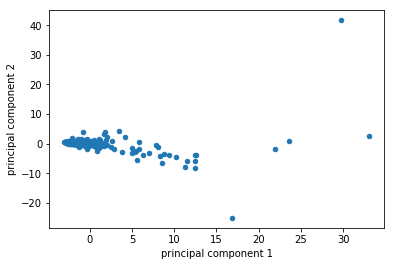

In [34]:
%matplotlib inline

principalDf.plot.scatter(x='principal component 1',y='principal component 2')

There is explanatory power in a statistical sence
In terms of a narrative its not as easy. This is due to the four neighborhoods with a high number of venues


In [38]:
x_travel = StandardScaler().fit_transform(travel_venues_df.values) 

pca2 = PCA(n_components=2)
pca2.fit(x_travel)

principalComponents_travel = pca2.transform(x_travel)
principalDf_travel = pd.DataFrame(data = principalComponents_travel
             , columns = ['principal component 1', 'principal component 2'])

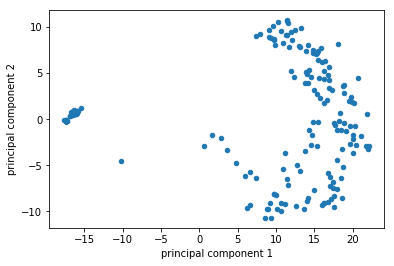

In [39]:
principalDf_travel.plot.scatter(x='principal component 1', y='principal component 2')

In [45]:
print('The two first principal components explain {:.1%} of the variance in the local data'.format(
    sum(pca.explained_variance_ratio_)
    ))
print('The two first principal components explain {:.1%} % of the variance in the travel data'.format(
    sum(pca2.explained_variance_ratio_ )
    ))


The two first principal components explain 9.6% of the variance in the local data
The two first principal components explain 81.3% % of the variance in the travel data


## Visualize the neighborhoods in a map 

Use the geocoding from travel time to get longetiude and altitude of Central Park in New York

Use the longitude and latitude to make a map of manhattan

Add labels for every neigbouthoods into the manhattan map

In [58]:
query = 'Murray Hill, New York'
URI_traveltime = 'HTTPS://api.traveltimeapp.com/v4/geocoding/search?query={}'.format(query)
print('URI is : {}'.format(URI_traveltime))
headers = {'Host': 'api.traveltimeapp.com',
           'Accept': 'application/json', 
           'X-Application-Id': secrets.APP_ID, # APP ID is in separate file not under version control
           'X-Api-Key': secrets.API_KEY} # API_KEY is in separate file not under version control
result = requests.get(URI_traveltime, headers=headers)
print(result.status_code, result.reason)

URI is : HTTPS://api.traveltimeapp.com/v4/geocoding/search?query=Murray Hill, New York
200 OK


In [59]:
new_york_location_data = result.json()['features'][0]
[longitude, latitude] = new_york_location_data['geometry']['coordinates']
print(longitude, latitude)

-73.979498 40.748085


In [60]:
# create map of Manhattan using latitude and longitude values
map_new_york = folium.Map(location=[latitude, longitude], zoom_start=11)

locations = neighborhoods_final.loc[:, 'Neighborhood']
latitudes = neighborhoods_final.loc[:, 'Latitude']
longitudes = neighborhoods_final.loc[:, 'Longitude']

# add markers to map
for lat, lng, label in zip(latitudes, longitudes, locations):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_new_york)  
map_new_york